In [1]:
import jax
import jax.numpy as jnp
from jax import config
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, evolve_perturbations_batched, get_power

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

config.update("jax_enable_x64", True)
dtype = jnp.float64

In [2]:
!pip list | grep -E 'jax|numpy|diffrax'

cosmopower_jax                    0.5.5
diffrax                           0.7.0
jax                               0.5.0
jax_autovmap                      0.2.1
jax-cosmo                         0.1.0
jax-cuda12-pjrt                   0.5.0
jax-cuda12-plugin                 0.5.0
jax-tqdm                          0.1.1
jaxlib                            0.5.0
jaxopt                            0.6
jaxtyping                         0.2.34
numpy                             1.26.4


### Generating parameters via Latin Hypercube

In [2]:
cosmo_params_names = ['omega_b', 'omega_cdm', 'h', 'n_s', 'ln10^{10}A_s', 'z']

ob_h2 =     np.array([0.01865, 0.02625])
omc_h2 =    np.array([0.05,    0.255])
h =         np.array([0.64,    0.82])
ns =        np.array([0.84,    1.1])
lnAs =      np.array([1.61,    3.91])
# cmin =      np.array([2.,      4.])
# eta0 =      np.array([0.5,     1.])
z =         np.array([0,       5.])

cosmo_params_bounds = np.stack([ob_h2, omc_h2, h, ns, lnAs, z])
print(cosmo_params_bounds.shape)

(6, 2)


In [3]:
def generate_lhs_samples(n_samples, bounds_array, seed=None):
    """
    Generate reproducible Latin Hypercube Samples with bounds as a NumPy array.

    Parameters:
    - n_samples (int): Number of samples to generate.
    - bounds_array (np.ndarray): Array of shape (n_dimensions, 2),
                                 each row is [min, max] for one parameter.
    - seed (int or None): Seed for reproducibility.

    Returns:
    - np.ndarray: (n_samples x n_dimensions) array of samples.
    """
    bounds_array = np.asarray(bounds_array)
    if bounds_array.ndim != 2 or bounds_array.shape[1] != 2:
        raise ValueError("bounds_array must be of shape (n_dimensions, 2)")

    n_dimensions = bounds_array.shape[0]

    # Latin Hypercube sampler with seed
    sampler = qmc.LatinHypercube(d=n_dimensions, seed=seed)
    unit_samples = sampler.random(n=n_samples)

    # Scale samples to custom bounds
    l_bounds = bounds_array[:, 0]
    u_bounds = bounds_array[:, 1]
    scaled_samples = qmc.scale(unit_samples, l_bounds, u_bounds)

    return scaled_samples

In [4]:
n_samples = 10_000
cosmo_params_samples = generate_lhs_samples(n_samples, cosmo_params_bounds, seed=42)
print(cosmo_params_samples.shape)

(10000, 6)


In [5]:
import itertools

def plot_2d_slices(samples, figsize=(12, 10)):
    n_dimensions = samples.shape[1]
    pairs = list(itertools.combinations(range(n_dimensions), 2))
    n_plots = len(pairs)

    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (dim1, dim2) in enumerate(pairs):
        ax = axes[i]
        ax.scatter(samples[:, dim1], samples[:, dim2], s=40, alpha=0.7)
        ax.set_xlabel(f'Dim {dim1}')
        ax.set_ylabel(f'Dim {dim2}')
        ax.set_title(f'Dim {dim1} vs Dim {dim2}')
        ax.grid(True)

    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    plt.show()

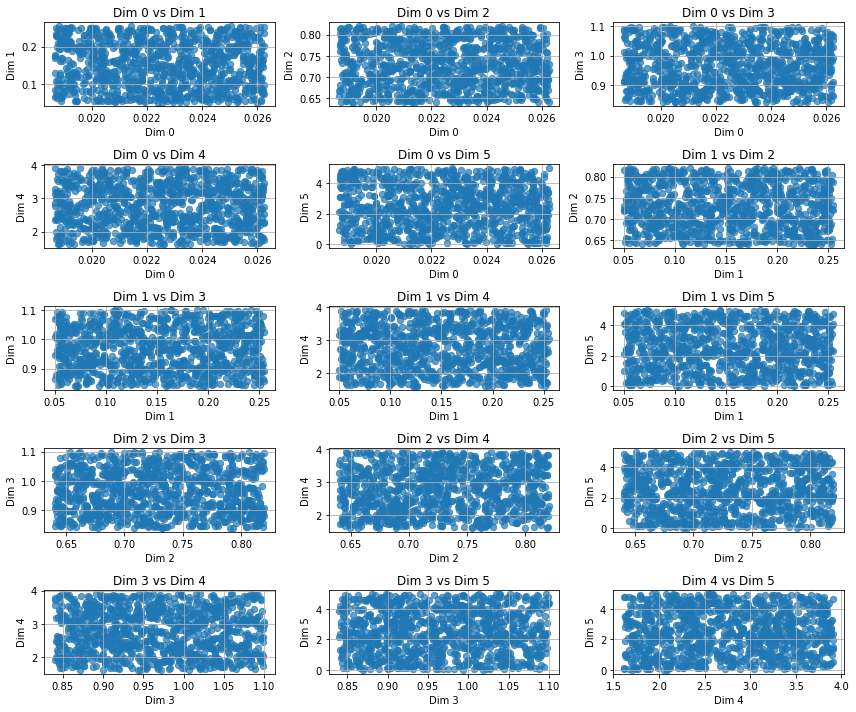

In [6]:
plot_2d_slices(cosmo_params_samples[:1000])

In [33]:
# training_data = {}
# training_data['cosmo_params_samples'] = cosmo_params_samples
# np.savez('./training_data/training_data_disco_eb.npz', **training_data)

### Power spectrum function

In [2]:
training_data = np.load('./training_data/training_data_disco_eb.npz')
training_data = {key: training_data[key] for key in training_data.files}

cosmo_params_samples = training_data['cosmo_params_samples']
Pks = training_data['power_spectra']

In [13]:
@jax.jit
def compute_matter_power(cosmo_params):
    ob_h2, omc_h2, h, ns, lnAs, z = cosmo_params
    param = {}
    param['Omegam'] = (omc_h2 + ob_h2) / h**2
    param['Omegab'] = ob_h2 / h**2
    param['w_DE_0'] = -0.99
    param['w_DE_a'] = 0.0
    param['cs2_DE'] = 0.99  # sound speed of DE
    param['Omegak'] = 0.0  # NOTE: Omegak is ignored at the moment!
    param['A_s'] = jnp.exp(lnAs) * 1e-10
    param['n_s'] = ns
    param['H0'] = h * 100  # Hubble constant in km/s/Mpc
    param['Tcmb'] = 2.72548  # CMB temperature in K
    param['YHe'] = 0.248
    Neff = 3.046  # -1 if massive neutrino present
    N_nu_mass = 1.0
    Tnu = (4.0 / 11.0) ** (1.0 / 3.0)
    N_nu_rel = Neff - N_nu_mass * (Tnu / ((4.0 / 11.0) ** (1.0 / 3.0))) ** 4
    param['Neff'] = N_nu_rel
    param['Nmnu'] = N_nu_mass
    param['mnu'] = 0.06  # eV
    param['k_p'] = 0.05  # pivot scale for the primordial power spectrum in Mpc^-1
    param_bg = evolve_background(param=param, thermo_module='RECFAST')
    aexp_out = 1/(1 + z)

    # Compute perturbations
    y, kmodes = evolve_perturbations(param=param_bg, kmin=1e-5, kmax=1e1, num_k=256,
                        aexp_out=jnp.array([aexp_out]), lmaxg=11, lmaxgp=11, lmaxr=11, lmaxnu=11,
                        nqmax=3, max_steps=2048, rtol=1e-4, atol=1e-4)

    # Get the power spectrum at z=0
    Pk = get_power(k=kmodes, y=y[:, 0, :], idx=4, param=param_bg)

    # Convert to /h units
    # h = param['H0'] / 100.0
    Pk_in_Mpc_h = Pk * h** 3
    kmodes_in_Mpc_h = kmodes / h
    return Pk_in_Mpc_h, kmodes_in_Mpc_h

In [4]:
Pk_in_Mpc_h, kmodes_in_Mpc_h = compute_matter_power(cosmo_params=cosmo_params_samples[0])

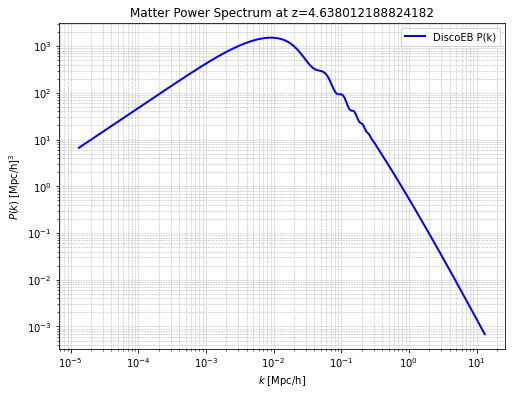

In [5]:
# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.loglog(kmodes_in_Mpc_h, Pk_in_Mpc_h, label='DiscoEB P(k)', color='blue', linewidth=2)
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.title(f'Matter Power Spectrum at z={cosmo_params_samples[0][-1]}')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

### Comparison with CLASS

In [6]:
from classy import Class

def get_pk_class(params, z, k, non_lin = False):
    """While params is the cosmological parameters, z is a single redshift,
    while k is an array of k values in units of h/Mpc.
    The returned power spectrum is in units of (Mpc/h)³.
    """
    h = params['h']
    params.update({
        'output': 'mPk',
        'P_k_max_h/Mpc': np.max(k),
        'z_max_pk': z,
    })
    cosmo = Class() 
    cosmo.set(params)
    cosmo.compute()
    if non_lin:
        pk_class = h**3 * np.array([cosmo.pk(h*ki, z) for ki in k])
    else:
        pk_class = h**3 * np.array([cosmo.pk_lin(h*ki, z) for ki in k])
    return pk_class

ob_h2, omc_h2, h, ns, lnAs, z = cosmo_params_samples[0]
cosmo = {
        'h': h,
        'omega_b': ob_h2,
        'omega_cdm': omc_h2,
        'ln10^{10}A_s': lnAs,
        'n_s': ns,
        'non linear': 'halofit',
        # 'sigma8': 0.834,
    }

pk_class = get_pk_class(cosmo, z, kmodes_in_Mpc_h)

In [9]:
## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
# Omegam  = 0.3099
# Omegab  = 0.0488911
# Omegac  = Omegam - Omegab
w_DE_0  = -0.99
w_DE_a  = 0.0
cs2_DE  = 1.0
# Initialize neutrinos.
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
# h       = 0.67742
# A_s     = 2.1064e-09
# n_s     = 0.96822
k_p     = 0.05

# modes to sample
nmodes = 512
kmin = 1e-5
kmax = 1e+2 # 1e+1
aexp = 0.01

In [ ]:
from classy import Class
from scipy.interpolate import interp1d

ob_h2, omc_h2, h, ns, lnAs, z = cosmo_params_samples[0]

LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({
    'h': h,
    'omega_b': ob_h2,
    'omega_cdm': omc_h2,
    'ln10^{10}A_s': lnAs,
    'n_s': ns,
    'Omega_k':0.0,
    'N_ur':N_nu_rel,
    'N_ncdm':N_nu_mass,
    'm_ncdm':mnu,
    'T_ncdm':    Tnu,
    # 'tau_reio':0.06, 
    'gauge':'synchronous',
    'reio_parametrization' : 'reio_none',
    'k_per_decade_for_pk' : 100,
    'k_per_decade_for_bao' : 100,
    # 'compute damping scale' : 'yes',
    # 'tol_perturbations_integration' : 1e-07,
    # 'tol_background_integration' : 1e-07,
    # 'hyper_flat_approximation_nu' : 7000,
    'T_cmb':Tcmb,
    'YHe':YHe,
    'output':'mPk,mTk,vTk',
    #'lensing':'no',
    'P_k_max_1/Mpc': kmax*1.01,
    'z_max_pk':1000.0,
    # 'recombination' : 'HyRec',
    'recombination' : 'RECFAST',
    # # these are high precision reference settings
    # 'start_small_k_at_tau_c_over_tau_h' : 0.0004,
    # 'start_large_k_at_tau_h_over_tau_k' : 0.05,
    # 'tight_coupling_trigger_tau_c_over_tau_h' : 0.005,
    # 'tight_coupling_trigger_tau_c_over_tau_k' : 0.008,
    # 'start_sources_at_tau_c_over_tau_h' : 0.006,
    
    'l_max_g' : 31,
    'l_max_pol_g' : 31,
    'l_max_ur' : 31,
    'l_max_ncdm' : 31,
    'Omega_Lambda' : 0.0,
    'w0_fld' : w_DE_0,
    'wa_fld' : w_DE_a,
    'cs2_fld' : 1.0,
    'use_ppf' : 'no',
    'radiation_streaming_approximation' : 2,
    'ncdm_fluid_approximation' : 3,
    'ur_fluid_approximation' : 2,
  })
# run class
# tic = time.time()
LambdaCDM.compute()
thermo = LambdaCDM.get_thermodynamics()
# toc = time.time()

# print("elapsed:", toc - tic)

def get_class_power( fieldname, zout ):
  tk, k, z = LambdaCDM.get_transfer_and_k_and_z()
  TT = interp1d( np.log(1/(1+z)), tk[fieldname], axis=1 )( np.log(1/(1+zout)) ) 
  # res =  2*np.pi**2*A_s*(k/k_p*h)**(n_s - 1) * k**(-3) * TT**2 
  res =  2*np.pi**2*A_s*(k/k_p)**(n_s - 1) * k**(-3) * TT**2
  return res, k


# Pkc_CLASS, k_CLASS = get_class_power('d_cdm', zout=z)

Pkm_CLASS = np.array([LambdaCDM.pk_lin(ki * h, z) for ki in kmodes_in_Mpc_h])
Pkm_CLASS_in_Mpc_h = Pkm_CLASS * h**3

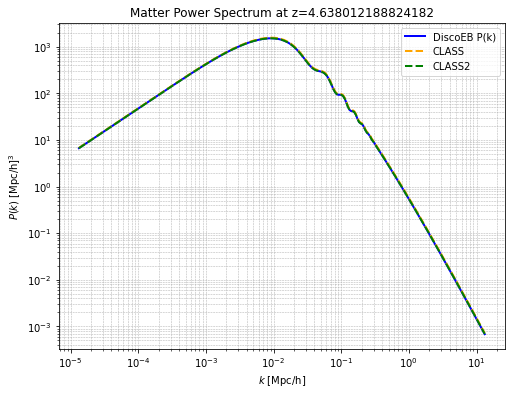

In [13]:
# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.loglog(kmodes_in_Mpc_h, Pk_in_Mpc_h, label='DiscoEB P(k)', color='blue', linewidth=2)
# plt.loglog(kmodes_in_Mpc_h, Pks[0], label='DiscoEB P(k)', color='blue', linewidth=2)
plt.loglog(kmodes_in_Mpc_h, pk_class, label='CLASS', color='orange', linestyle='--', linewidth=2)
plt.loglog(kmodes_in_Mpc_h, Pkm_CLASS_in_Mpc_h, label='CLASS2', color='green', linestyle='--', linewidth=2)
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.title(f'Matter Power Spectrum at z={z}')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

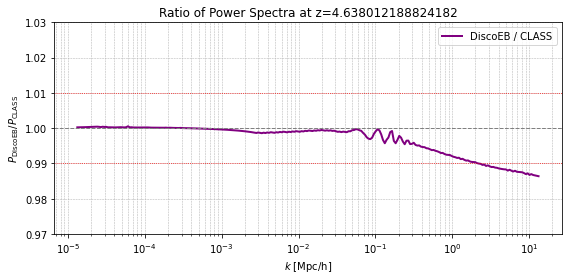

In [20]:
# Compute the ratio
ratio = Pk_in_Mpc_h / Pkm_CLASS_in_Mpc_h #pk_class

# Plot the ratio
plt.figure(figsize=(8, 4))
plt.semilogx(kmodes_in_Mpc_h, ratio, color='purple', linewidth=2, label=r'DiscoEB / CLASS')

# Add a reference line at 1
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)

# Optionally highlight ±1% deviation
plt.axhline(1.01, color='red', linestyle=':', linewidth=0.8)
plt.axhline(0.99, color='red', linestyle=':', linewidth=0.8)

plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P_{\mathrm{DiscoEB}} / P_{\mathrm{CLASS}}$')
plt.title(f'Ratio of Power Spectra at z={z}')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.ylim([0.97, 1.03])
plt.tight_layout()
plt.show()

### Batched Pk function

In [5]:
_compute_matter_power_batched_impl = jax.vmap(compute_matter_power)

def compute_matter_power_batched(cosmo_params_batch):
    batch = _compute_matter_power_batched_impl(cosmo_params_batch)
    Pk_batch, kmodes = batch[0], batch[1][0]
    return Pk_batch, kmodes

In [75]:
Pk_in_Mpc_h_batch, kmodes_in_Mpc_h = compute_matter_power_batched(cosmo_params_samples[:1000])

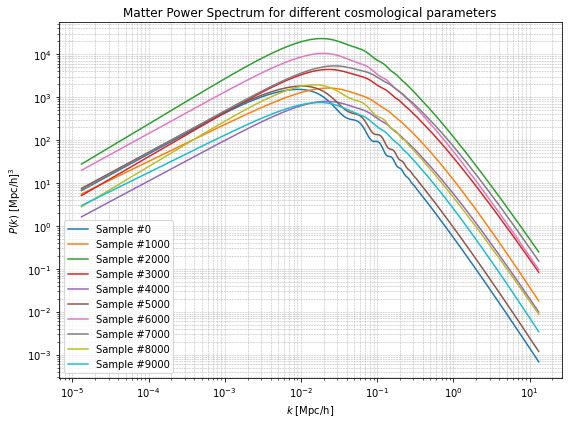

In [6]:
plt.figure(figsize=(8, 6))
Pk_in_Mpc_h_batch = training_data['power_spectra']
kmodes_in_Mpc_h = training_data['k_modes']

for i in range(0, len(Pk_in_Mpc_h_batch), 1000):
    Pk = Pk_in_Mpc_h_batch[i]
    plt.loglog(kmodes_in_Mpc_h, Pk, linewidth=1.5, label=f'Sample #{i}',)

plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.title('Matter Power Spectrum for different cosmological parameters')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Computing the gradients

In [16]:
# might take ~ 2 minutes to compile on first run, ~5s on rerun (RTX3090), 
# increase accuracy (rtol,atol) to reduce noise on derivatives

diff_matter_power = jax.jacfwd(compute_matter_power)
dPkm, _ = diff_matter_power(cosmo_params_samples[0])

In [28]:
# finite difference
epsilon = 1e-4
Pkm_plus,_  = compute_matter_power(cosmo_params_samples[0] + epsilon * jnp.array([0, 1., 0, 0, 0, 0])) #derivative with respect to second argument, omc_h2
Pkm_minus,_ = compute_matter_power(cosmo_params_samples[0] - epsilon * jnp.array([0, 1., 0, 0, 0, 0]))
dPkm_fd1     = (jnp.log(Pkm_plus)-jnp.log(Pkm_minus))/2e-4

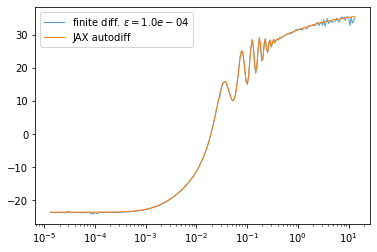

In [38]:
fig, ax = plt.subplots()
ax.semilogx(kmodes_in_Mpc_h, dPkm_fd1, label=f'finite diff. $\\epsilon={epsilon:.1e}$', alpha=0.75, lw=1)
ax.semilogx(kmodes_in_Mpc_h, dPkm[:, 1] / Pk_in_Mpc_h, label='JAX autodiff', lw=1)
# ax.set_xlabel(r'$k\; [\text{Mpc}^{1}]$')
# ax.set_ylabel(r'$\partial \log P(k)/\partial \log \Omega_m\;[1]$')
# ax.set_ylim(-2,3)
ax.legend()

### Batched gradient computation

In [5]:
_diff_matter_power_batched_impl = jax.vmap(diff_matter_power)

def diff_matter_power_batched(cosmo_params_batch):
    dPkm_batch, _ = _diff_matter_power_batched_impl(cosmo_params_batch)
    # dPkm_batch = np.transpose(dPkm_batch, (0, 2, 1))
    return dPkm_batch

In [ ]:
dPkm_batch, _ = diff_matter_power_batched(cosmo_params_samples[:50])

In [61]:
dPkm_batch.shape

(75, 6, 256)

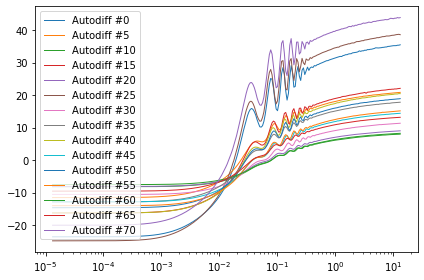

In [62]:
fig, ax = plt.subplots()

# Assume:
# dPkm.shape = (batch_size, num_k)
# Pk_in_Mpc_h.shape = (num_k,)
# kmodes_in_Mpc_h.shape = (num_k,)
# Omegam_fid is a scalar

for i in range(0, len(dPkm_batch), 10):
    ax.semilogx(
        kmodes_in_Mpc_h,
        dPkm_batch[i, 1, :] / Pks[i], #Pk_in_Mpc_h_batch[i],
        label=f'Autodiff #{i}',
        lw=1
    )

# ax.set_ylim(-2, 6)
ax.legend()
plt.tight_layout()
plt.show()

### Hessian and JVP computation

In [8]:
# hess_matter_power = jax.hessian(compute_matter_power)
hess_Pkm, _ = hess_matter_power(cosmo_params_samples[0])

In [7]:
hess_Pkm.shape

(256, 6, 6)

In [6]:
# ~9 mins on the first run, ~50 s after compilation 
# hessian_matter_power = jax.jacfwd(jax.jacfwd(compute_matter_power))
hess_Pkm, _ = hessian_matter_power(cosmo_params_samples[0])